- Filename: Eval-TrajIonianSea_Plot-Fig6Fig7.ipynb
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: June 2023
- Last updated: Mar 26th 2024
- Description: Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., used to produce Figures 6 and 7

# Comparing virtual particle trajectories from ocean-only (non-coupled) and ocean-wave (coupled) model simulations for the Ionian Sea (Mediterranean Sea subregion 9)

## 1. General Settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import os.path
from datetime import timedelta, datetime
from glob import glob


In [2]:
col_blue = (68/255, 119/255, 170/255)
col_cyan = (102/255, 204/255, 238/255)
col_green = (34/255, 136/255, 51/255)
col_yellow = (204/255, 187/255, 68/255)
col_red = (238/255, 102/255, 119/255)
col_purple = (170/255, 51/255, 119/255)
col_grey = (187/255, 187/255, 187/255)

## 2. Loading and formatting trajectory data

In [3]:
############################

# set zarrdata to False if Parcels_CalcTraj.ipynb has not been executed
# then the trajectory data in netcdf format will be loaded
zarrdata = True

datapath = '../data-proc/traj/SubReg9/'

gridpath = '../data-orig/mesh_mask.nc'

############################


# Trajectories

tonetcdf = True  # set to True if you want to save trajectory data in netcdf format

if zarrdata == True:
    trajpaths_csd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-sd_Release-SubReg9-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                           key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_csd = xr.open_mfdataset(trajpaths_csd,
                                 concat_dim="start", combine="nested",
                                 engine="zarr")

    trajpaths_cnosd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-nosd_Release-SubReg9-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                             key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_cnosd = xr.open_mfdataset(trajpaths_cnosd,
                                   concat_dim="start", combine="nested",
                                   engine="zarr")

    trajpaths_nc = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled_Release-SubReg9-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_nc = xr.open_mfdataset(trajpaths_nc,
                                concat_dim="start", combine="nested",
                                engine="zarr")

    trajpaths_ncsd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled-sd_Release-SubReg9-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                            key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_ncsd = xr.open_mfdataset(trajpaths_ncsd,
                                  concat_dim="start", combine="nested",
                                  engine="zarr")
    if tonetcdf == True:
        traj_csd.to_netcdf(datapath + "Trajectories_BestGuess_coupled-sd.nc")
        traj_cnosd.to_netcdf(
            datapath + "Trajectories_Sensitivity_coupled-nosd.nc")
        traj_nc.to_netcdf(datapath + "Trajectories_OldStandard_uncoupled.nc")
        traj_ncsd.to_netcdf(
            datapath + "Trajectories_Approximation_uncoupled-sd.nc")
else:
    traj_csd = xr.open_dataset(
        datapath + "Trajectories_BestGuess_coupled-sd.nc")
    traj_cnosd = xr.open_dataset(
        datapath + "Trajectories_Sensitivity_coupled-nosd.nc")
    traj_nc = xr.open_dataset(
        datapath + "Trajectories_OldStandard_uncoupled.nc")
    traj_ncsd = xr.open_dataset(
        datapath + "Trajectories_Approximation_uncoupled-sd.nc")


# Grid

grid = xr.open_dataset(gridpath, drop_variables=("x", "y"))

## 3. Additional Analysis

 ### 3.1 Calculate Lagrangian velocity speed and direction along trajectory

In [4]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

In [5]:
# calculation of unit vector mean current direction
def calc_trajveldir(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    veldir = 180 + 180/np.pi*(np.arctan2(-u,-v)) 
    return veldir

In [6]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_cnosd = calc_trajspeed(traj_cnosd)
trajspeed_nc = calc_trajspeed(traj_nc)
trajspeed_ncsd = calc_trajspeed(traj_ncsd)

In [7]:
trajveldir_csd = calc_trajveldir(traj_csd)
trajveldir_cnosd = calc_trajveldir(traj_cnosd)
trajveldir_nc = calc_trajveldir(traj_nc)
trajveldir_ncsd = calc_trajveldir(traj_ncsd)

### 3.2 Check whether particles beached

In [8]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=('obs'))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [9]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print('Total number of released particles per dataset:', str(npart))
print('number of beached particles:')
print('coupled with Stokes drift:', str(calc_npaticles_beached(traj_csd)),
      ' (', str(round(calc_npaticles_beached(traj_csd)/npart*100)), '%)')
print('coupled without Stokes drift:', str(calc_npaticles_beached(traj_cnosd)),
      ' (', str(round(calc_npaticles_beached(traj_cnosd)/npart*100)), '%)' )
print('uncoupled without Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )
print('uncoupled with Stokes drift:', str(calc_npaticles_beached(traj_ncsd)),
      ' (', str(round(calc_npaticles_beached(traj_ncsd)/npart*100)), '%)' )

Total number of released particles per dataset: 109427
number of beached particles:
coupled with Stokes drift: 58.0  ( 0 %)
coupled without Stokes drift: 57.0  ( 0 %)
uncoupled without Stokes drift: 52.0  ( 0 %)
uncoupled with Stokes drift: 60.0  ( 0 %)


In [10]:
def calc_npaticles_stucked(trajspeed):
    tmp = xr.where(trajspeed <= 1e-8, trajspeed/trajspeed, trajspeed*0).sum(dim=('obs'))
    stucked_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return stucked_trajset.values

In [11]:
print('number of stucked particles:')
tmp = calc_npaticles_stucked(trajspeed_csd)
print('coupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)')
tmp = calc_npaticles_stucked(trajspeed_cnosd)
print('coupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_nc)
print('uncoupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_ncsd)
print('uncoupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )

number of stucked particles:


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled with Stokes drift: 46.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled without Stokes drift: 36.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled without Stokes drift: 35.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled with Stokes drift: 45.0  ( 0 %)


### 3.3  Calculate general dispersal statistics: along-track distance and net displacement

In [12]:
# Along-track velocity averaged along each trajectory

def calc_LAvel_tmean(trajspeed):
    trajspeed_tmean = trajspeed.mean(dim='obs')
    
    return trajspeed_tmean

In [13]:
# Geographical distance
# (this function is partially from Laura)
 
def dist_km(lona, lonb, lata, latb):

    # convert degrees in radians
    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    # haversine formula
    # i.e. calculate distance on a sphere
    R = 6373.0 # approximate radius of earth in km
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

In [14]:
# Magnitude of (net) displacement in km

def displacement(trajset,tobs):

    lona = trajset.isel(obs=0).lon
    lonb = trajset.isel(obs=tobs).lon
    lata = trajset.isel(obs=0).lat
    latb = trajset.isel(obs=tobs).lat

    disp = xr.apply_ufunc(dist_km, lona, lonb, lata, latb, dask="allowed") 

    return disp
    

In [15]:
# Direction of (net) displacement

def displacement_dir(trajset,tobs):

    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    u_tint = u.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)
    v_tint = v.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)

    dispdir = 180 + 180/np.pi*np.arctan2(-u_tint,-v_tint)
    
    return dispdir
    

In [16]:
# along-track distance (also called cumulative distance)

def calc_displacement_stats(trajspeed,dtout):
    #dtout is the output frequency in seconds
    # 1. Cumulative displacement for each particle
    ## obtained by integrating over along-track velocities
    partdist = trajspeed * dtout
    dist = (partdist.cumsum(dim='obs', skipna=True)) # in m
    # 2. Residual displacement 
    ## obtained by subtracting the mean displacement of all particles
    Dist_total = dist.mean(dim=['trajectory','start'])
    resdist_total = dist - Dist_total
    # 2. Residual displacement - time
    ## obtained by subtracting the mean displacement D of all particles
    ## - released at the same location
    ## - but at different start times
    Dist_time = dist.mean(dim=['start'])
    resdist_time = dist - Dist_time
    # 2. Residual displacement - space
    ## obtained by subtracting the mean displacement of all particles
    ## - released at the same start time
    ## - but at all possible locations  
    Dist_space = dist.mean(dim=['trajectory'])
    resdist_space = dist - Dist_space
    return partdist, dist, resdist_total, resdist_time, resdist_space

def calc_quantiles(trajdist):
    dist_quantiles = trajdist.chunk(dict(start=-1)).quantile(q=[0, 0.25, 0.5, 0.75, 1], dim=('trajectory','start'))
    return dist_quantiles

In [17]:
trajspeed_tmean_csd = calc_LAvel_tmean(trajspeed_csd)
trajspeed_tmean_cnosd = calc_LAvel_tmean(trajspeed_cnosd)
trajspeed_tmean_nc = calc_LAvel_tmean(trajspeed_nc)
trajspeed_tmean_ncsd = calc_LAvel_tmean(trajspeed_ncsd)


In [18]:
traj_disp30d_csd = displacement(traj_csd, 30)
traj_disp30d_cnosd = displacement(traj_cnosd, 30)
traj_disp30d_nc = displacement(traj_nc, 30)
traj_disp30d_ncsd = displacement(traj_ncsd, 30)

In [19]:
traj_dispdir30d_csd = displacement_dir(traj_csd, 30)
traj_dispdir30d_cnosd = displacement_dir(traj_cnosd, 30)
traj_dispdir30d_nc = displacement_dir(traj_nc, 30)
traj_dispdir30d_ncsd = displacement_dir(traj_ncsd, 30)


In [20]:
partdist_csd, dist_csd, resdist_total_csd, resdist_time_csd, resdist_space_csd = calc_displacement_stats(
    trajspeed_csd, 86400)
partdist_cnosd, dist_cnosd, resdist_total_cnosd, resdist_time_cnosd, resdist_space_cnosd = calc_displacement_stats(
    trajspeed_cnosd, 86400)
partdist_nc, dist_nc, resdist_total_nc, resdist_time_nc, resdist_space_nc = calc_displacement_stats(
    trajspeed_nc, 86400)
partdist_ncsd, dist_ncsd, resdist_total_ncsd, resdist_time_ncsd, resdist_space_ncsd = calc_displacement_stats(
    trajspeed_ncsd, 86400)

In [21]:
dist_csd_quantiles = calc_quantiles(dist_csd).compute()
resdist_total_csd_quantiles = calc_quantiles(abs(resdist_total_csd)).compute()
resdist_space_csd_quantiles = calc_quantiles(abs(resdist_space_csd)).compute()
resdist_time_csd_quantiles = calc_quantiles(abs(resdist_time_csd)).compute()

dist_cnosd_quantiles = calc_quantiles(dist_cnosd).compute()
resdist_total_cnosd_quantiles = calc_quantiles(
    abs(resdist_total_cnosd)).compute()
resdist_space_cnosd_quantiles = calc_quantiles(
    abs(resdist_space_cnosd)).compute()
resdist_time_cnosd_quantiles = calc_quantiles(
    abs(resdist_time_cnosd)).compute()

dist_nc_quantiles = calc_quantiles(dist_nc).compute()
resdist_total_nc_quantiles = calc_quantiles(abs(resdist_total_nc)).compute()
resdist_space_nc_quantiles = calc_quantiles(abs(resdist_space_nc)).compute()
resdist_time_nc_quantiles = calc_quantiles(abs(resdist_time_nc)).compute()

dist_ncsd_quantiles = calc_quantiles(dist_ncsd).compute()
resdist_total_ncsd_quantiles = calc_quantiles(
    abs(resdist_total_ncsd)).compute()
resdist_space_ncsd_quantiles = calc_quantiles(
    abs(resdist_space_ncsd)).compute()
resdist_time_ncsd_quantiles = calc_quantiles(abs(resdist_time_ncsd)).compute()

## 4. Visualize results

### 4.1 Plot Figure 7

Text(450, 0, 'Frequency \n change [%]')

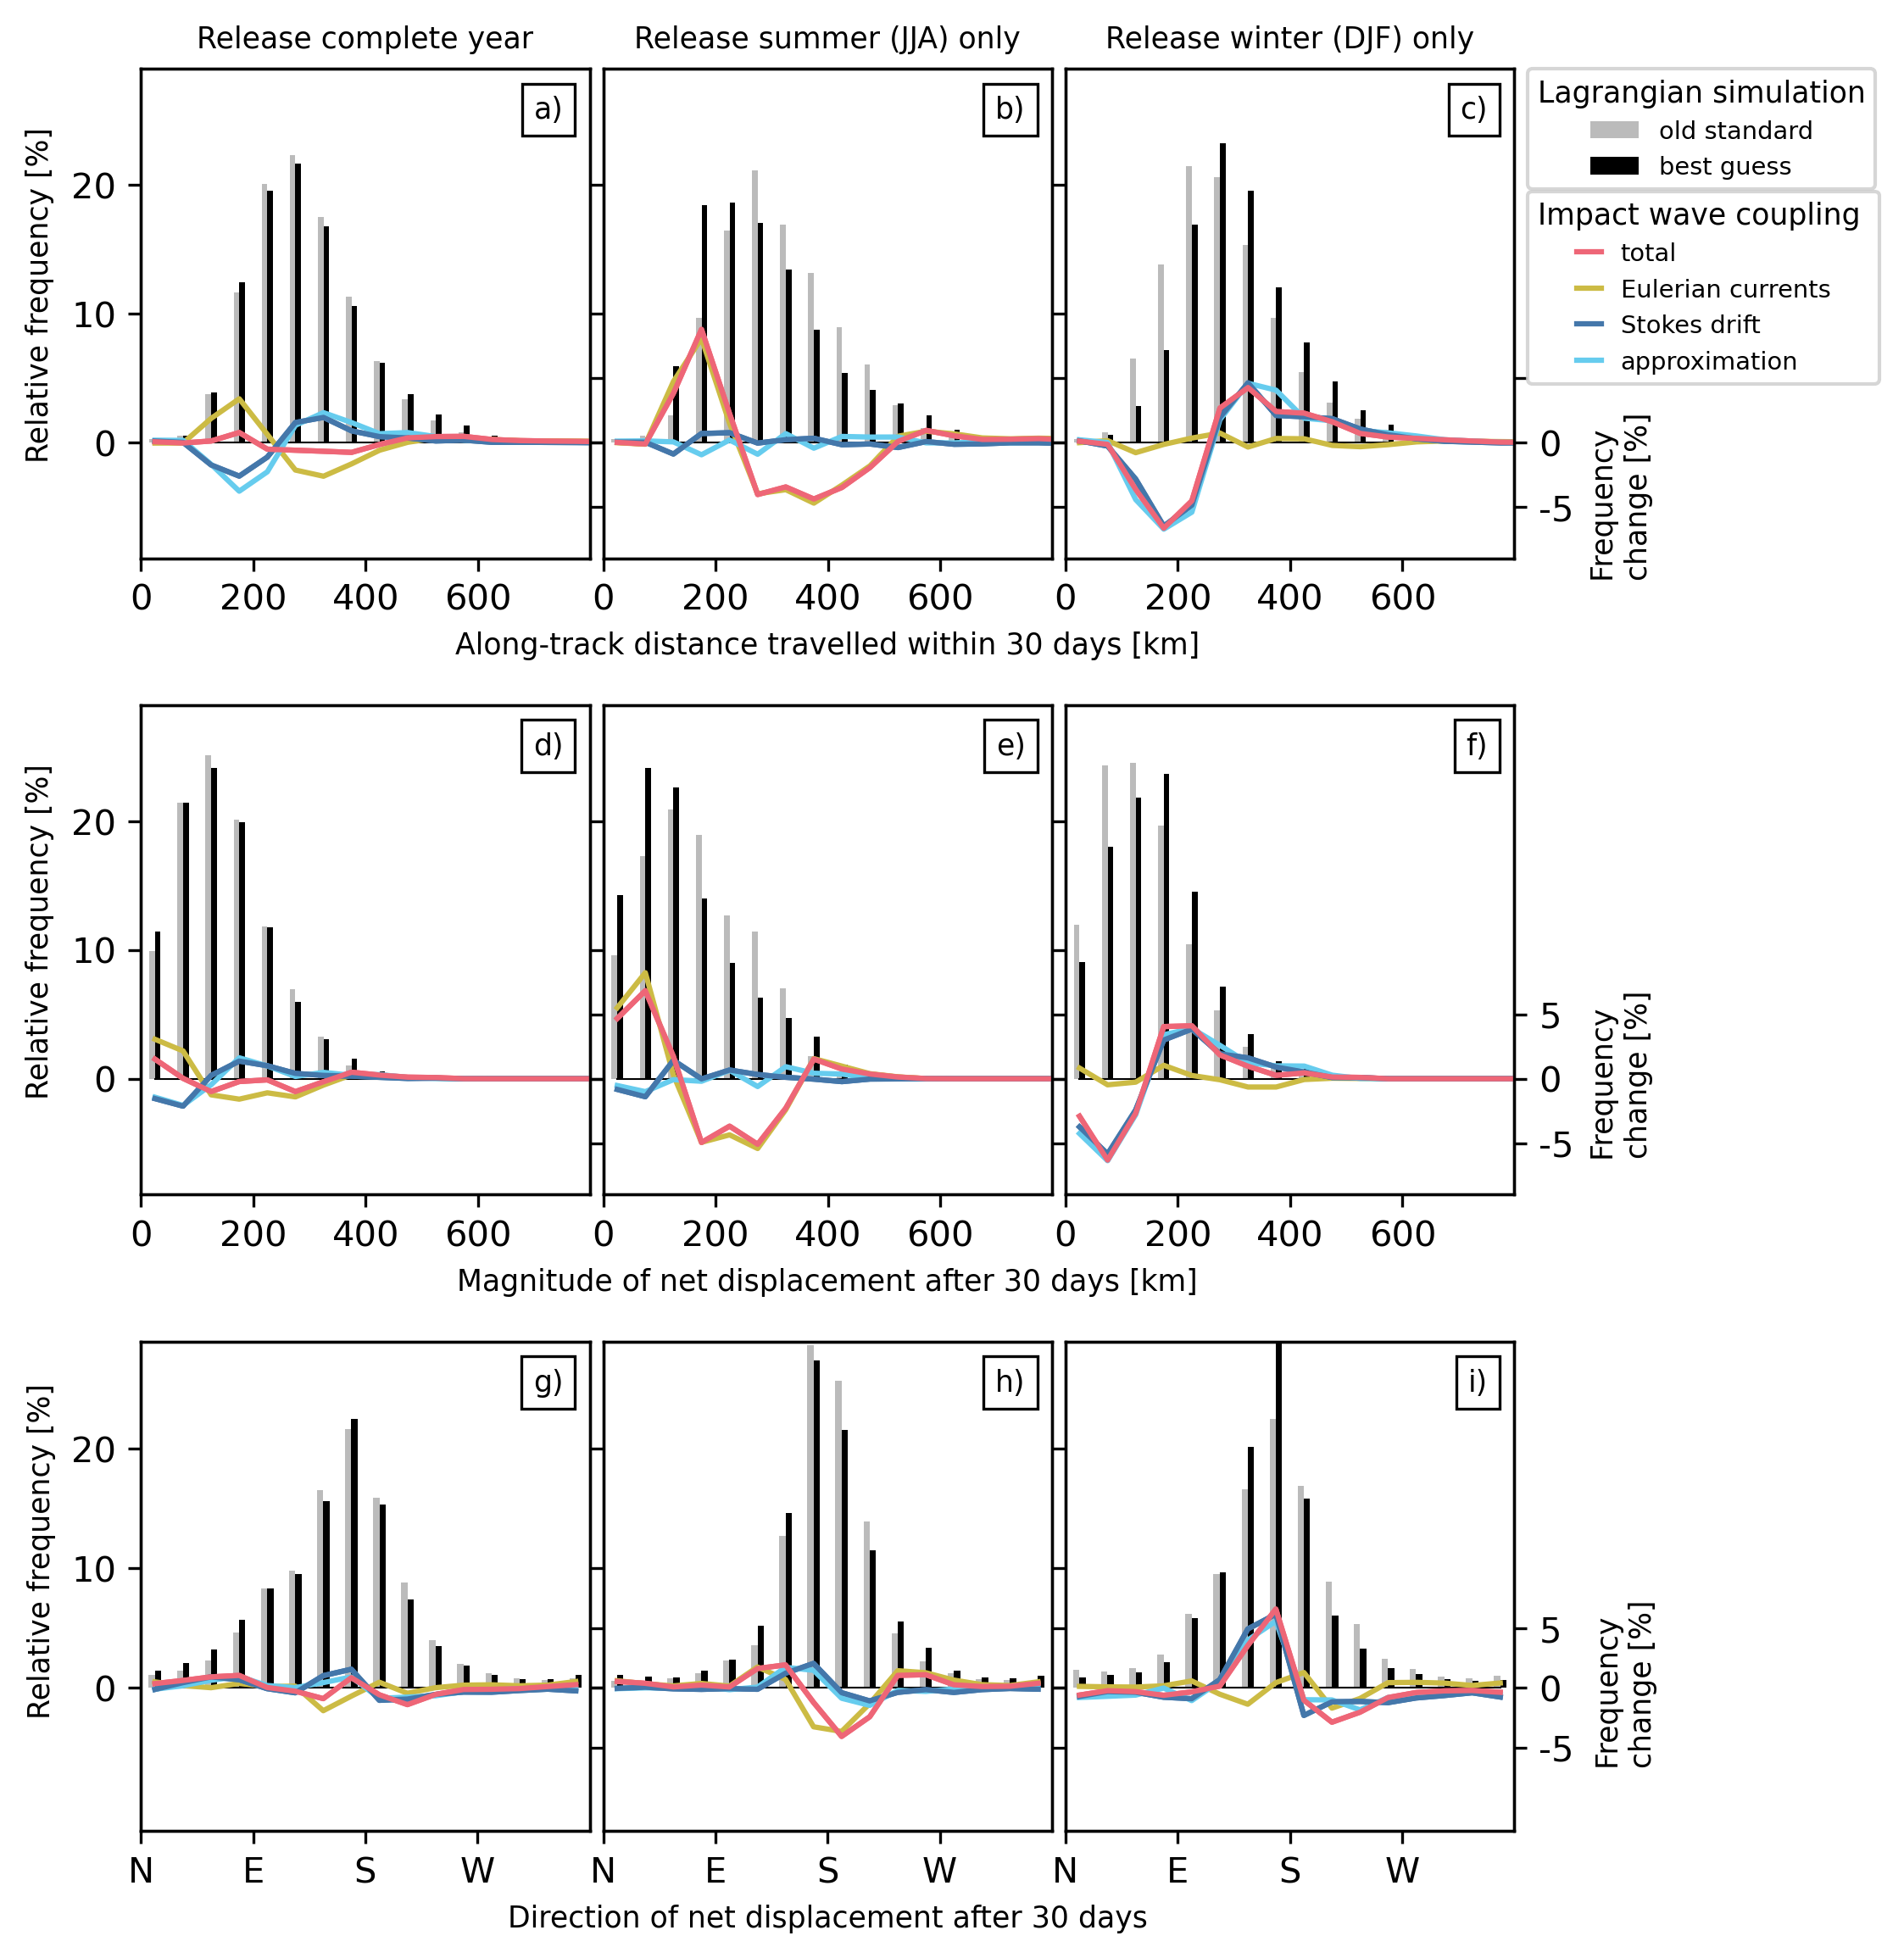

In [22]:
col_csd = 'k'
col_nc = col_grey
col_ncsd = col_purple
col_euler = col_yellow
col_stokes = col_blue
col_approx = col_cyan
col_total = col_red
lw1 = 1.5
lw_box = 0.8
fs = 'small'
fs2 = 'x-small'
tobs = 30

fig = plt.figure(figsize=(6, 9), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3,
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.3)


#######################################################
# Cumulative displacement/ along-track distance


bins = np.arange(0, 950, 50)
bar_width = 10
xlims = [0, 799]
ylims = [-9, 29]
yticks = [0, 10, 20]
yticks2 = [-5, 0, 5]
yticklabs2 = ['-5', '0', '']


# Distribution release whole year

var1 = dist_csd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(
    trajstack=('trajectory', 'start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[0, 0])
def plot_histcounts(xlim, ylim, ytick, binwidth):
    plt.bar(hist3b.dist_bin-binwidth/2, hist3b.values,
            width=bar_width, color=col_nc,
            label='old standard')
    plt.bar(hist1b.dist_bin+binwidth/2, hist1b.values,
            width=bar_width, color=col_csd,
            label='best guess')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks(ytick)
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.text(-180, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
ax.set_title('Release complete year', fontsize=fs)
at = AnchoredText('a)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
def plot_histdiff(xlim, ylim, ytick, yticklab):
    ax2.plot(hist1b.dist_bin, hist1b.dist_bin*0,
             color='k', linewidth=0.5)
    ax2.plot(hist1b.dist_bin, hist1b-hist3b,
             color=col_total, linewidth=lw1, label='total')
    ax2.plot(hist1b.dist_bin, hist2b-hist3b,
             color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax2.plot(hist1b.dist_bin, hist1b-hist2b,
             color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax2.plot(hist1b.dist_bin, hist4b-hist3b,
             color=col_approx, linewidth=lw1, label='approximation')
    ax2.plot(hist1b.dist_bin, hist1b-hist2b,
             color=col_stokes, linewidth=lw1)
    ax2.plot(hist1b.dist_bin, hist1b-hist3b,
             color=col_total, linewidth=lw1)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_yticks(ytick)
    ax2.set_yticklabels(yticklab)
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)


# Distribution summer

var1 = dist_csd.rename('dist').isel(obs=tobs, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[0, 1])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)
ax.set_xlabel(
    'Along-track distance travelled within 30 days [km]', fontsize=fs)
at = AnchoredText('b)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax2.set_yticklabels([])


# Distribution winter

l1 = np.arange(0, 12)
l2 = np.arange(67, 73)
l3 = [*l1, *l2]
var1 = dist_csd.rename('dist').isel(obs=tobs, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[0, 2])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)
at = AnchoredText('c)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax2.legend(bbox_to_anchor=(1.03, 0.75), loc='upper left',
           title='Impact wave coupling ', title_fontsize=fs,
           borderaxespad=0., fontsize=fs2,
           handlelength=1)
ax.text(990, -4.5, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')


#######################################################
# Magnitude net displacement


bins = np.arange(0, 950, 50)
bar_width = 10
yticklabs2 = ['-5', '0', '5']


# Distribution release whole year

var1 = traj_disp30d_csd.rename('dist').stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').stack(
    trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').stack(
    trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[1, 0])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.text(-180, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
at = AnchoredText('d)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)


# Distribution summer

var1 = traj_disp30d_csd.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[1, 1])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
ax.set_xlabel('Magnitude of net displacement after 30 days [km]', fontsize=fs)
at = AnchoredText('e)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax2.set_yticklabels([])


# Distribution winter

l1 = np.arange(0, 12)
l2 = np.arange(67, 73)
l3 = [*l1, *l2]
var1 = traj_disp30d_csd.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
var3 = traj_disp30d_nc.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[1, 2])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
at = AnchoredText('f)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax.text(990, 0, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')


#######################################################
# Direction of net displacement


bins = np.arange(0, 380.5, 22.5)
bar_width = 5
tobs = 30
xlims = [0, 360]
ylims = [-12, 29]
yticks = [0, 10, 20]
yticks2 = [-5, 0, 5]
yticklabs2 = ['-5', '0', '5']
xticks = [0, 90, 180, 270]
xticklabs = ['N', 'E', 'S', 'W']


# Distribution release whole year

var1 = traj_dispdir30d_csd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(
    obs=30).stack(trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[2, 0])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
# ax.set_ylabel('Relative frequency [%]', fontsize=fs)
ax.text(-80, 11.5, 'Relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center')
at = AnchoredText('g)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)


# Distribution summer

var1 = traj_dispdir30d_csd.rename('dist').isel(start=slice(
    31, 49), obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(start=slice(
    31, 49), obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(start=slice(
    31, 49), obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(start=slice(
    31, 49), obs=30).stack(trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[2, 1])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_xlabel('Direction of net displacement after 30 days', fontsize=fs)
at = AnchoredText('h)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax2.set_yticklabels([])


# Distribution winter

l1 = np.arange(0, 12)
l2 = np.arange(67, 73)
l3 = [*l1, *l2]
var1 = traj_dispdir30d_csd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(
    start=l3, obs=30).stack(trajstack=('trajectory', 'start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[2, 2])
plot_histcounts(xlim=xlims, ylim=ylims,
                ytick=yticks,
                binwidth=bar_width)
ax.set_yticklabels([])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
at = AnchoredText('i)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax2 = ax.twinx()
plot_histdiff(xlim=xlims, ylim=ylims,
              ytick=yticks2, yticklab=yticklabs2)
ax.text(450, 0, 'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center')

Text(0.5, 0, 'direction displacement')

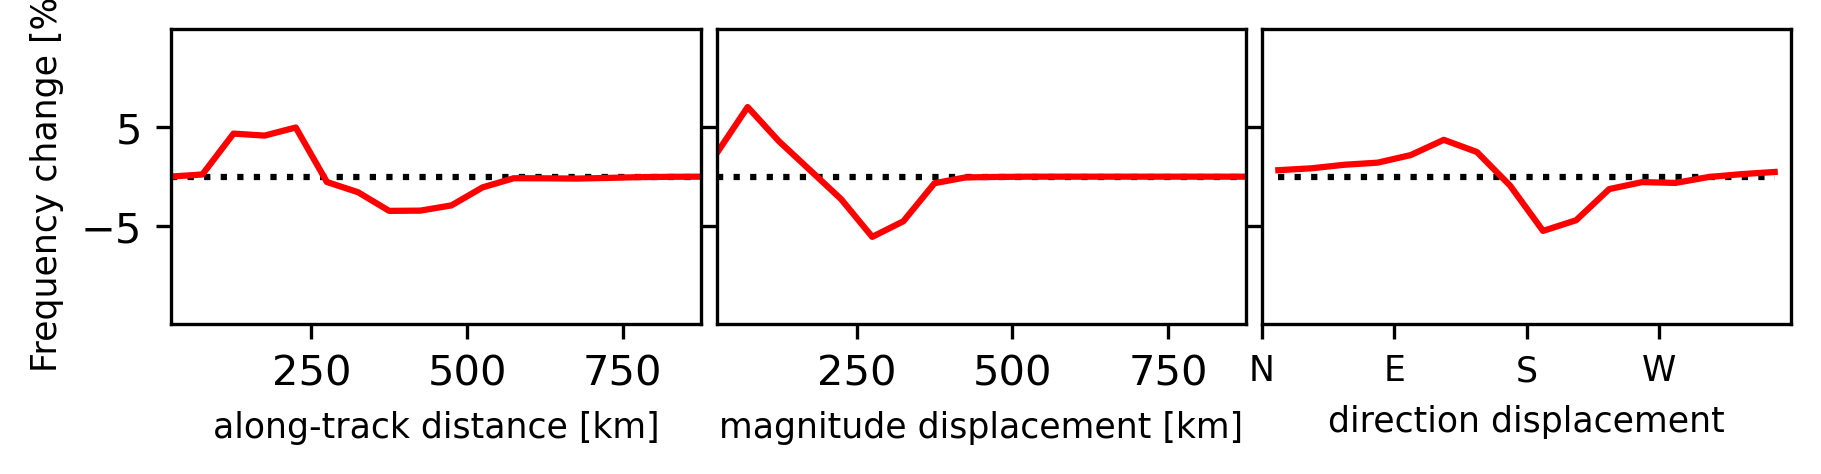

In [23]:
# Plot seasonal differences for best guess simulation
# (helpful for the manuscript)

def plot_histdiww_season(varS, varW, bins):
    histS = histogram(varS, bins=[bins])
    histSb = histS/histS.sum()*100
    histW = histogram(varW, bins=[bins])
    histWb = histW/histW.sum()*100
    ax.plot(histWb.dist_bin, histWb.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(histWb.dist_bin, histWb-histSb,
            color='r', linewidth=lw1)


fig = plt.figure(figsize=(6, 5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3,
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)

ax = fig.add_subplot(gs[2, 0])
bins = np.arange(0, 950, 50)
varS = dist_nc.rename('dist').isel(obs=30, start=slice(
    31, 49)).stack(trajstack=('trajectory', 'start'))/1000
varW = dist_nc.rename('dist').isel(obs=30, start=l3).stack(
    trajstack=('trajectory', 'start'))/1000
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([25, 875])
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_ylabel('Frequency change [%]', fontsize=fs)
ax.set_xlabel('along-track distance [km]', fontsize=fs)

ax = fig.add_subplot(gs[2, 1])
varS = traj_disp30d_nc.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
varW = traj_disp30d_nc.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([25, 875])
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_yticklabels([])
ax.set_xlabel('magnitude displacement [km]', fontsize=fs)

ax = fig.add_subplot(gs[2, 2])
bins = np.arange(0, 380.5, 22.5)
varS = traj_dispdir30d_nc.rename('dist').isel(
    start=slice(31, 49)).stack(trajstack=('trajectory', 'start'))
varW = traj_dispdir30d_nc.rename('dist').isel(
    start=l3).stack(trajstack=('trajectory', 'start'))
plot_histdiww_season(varS, varW, bins)
ax.set_xlim([0, 360])
xticks = [0, 90, 180, 270]
xticklabs = ['N', 'E', 'S', 'W']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs, fontsize=fs)
ax.set_ylim([-15, 15])
ax.set_yticks([-5, 5])
ax.set_yticklabels([])
ax.set_xlabel('direction displacement', fontsize=fs)

### 4.2 Print values for Table 3

In [24]:
print('Along-track distance')


tobs = 30
summerslice = slice(31, 49)
winterslice = l3


def print_meanstd_seasons(var):
    var_total = var.rename('dist').isel(obs=tobs).stack(
        trajstack=('trajectory', 'start'))/1000
    var_winter = var.rename('dist').isel(obs=tobs, start=winterslice
                                         ).stack(trajstack=('trajectory', 'start'))/1000
    var_summer = var.rename('dist').isel(obs=tobs, start=summerslice
                                         ).stack(trajstack=('trajectory', 'start'))/1000

    var_total_mean = var_total.mean()
    var_total_std = var_total.std()
    var_summer_mean = var_summer.mean()
    var_summer_std = var_summer.std()
    var_winter_mean = var_winter.mean()
    var_winter_std = var_winter.std()

    print('annual:'
          + str(np.round(var_total_mean.values, 2))
          + '+/-' + str(np.round(var_total_std.values, 2)) + 'km')
    print('summer:'
          + str(np.round(var_summer_mean.values, 2))
          + '+/-' + str(np.round(var_summer_std.values, 2)) + 'km')
    print('winter:'
          + str(np.round(var_winter_mean.values, 2))
          + '+/-' + str(np.round(var_winter_std.values, 2)) + 'km')

    return var_total_mean, var_total_std, var_summer_mean, var_summer_std, var_winter_mean, var_winter_std


print('Old standard')
var = dist_nc
dist_nc_total_mean, dist_nc_total_std, dist_nc_summer_mean, dist_nc_summer_std, dist_nc_winter_mean, dist_nc_winter_std = print_meanstd_seasons(
    var)

print('Best guess')
var = dist_csd
dist_csd_total_mean, dist_csd_total_std, dist_csd_summer_mean, dist_csd_summer_std, dist_csd_winter_mean, dist_csd_winter_std = print_meanstd_seasons(
    var)

print('Approximation')
var = dist_ncsd
dist_ncsd_total_mean, dist_ncsd_total_std, dist_ncsd_summer_mean, dist_ncsd_summer_std, dist_ncsd_winter_mean, dist_ncsd_winter_std = print_meanstd_seasons(
    var)


def print_error():
    print('Error Old standard:')
    print('annual:'
          + str(np.round((dist_nc_total_mean.values-dist_csd_total_mean.values), 2))
          + '(' + str(np.round((dist_nc_total_mean.values -
                                dist_csd_total_mean.values)/dist_csd_total_mean.values*100, 2))
            + '%)')
    print('summer:'
          + str(np.round((dist_nc_summer_mean.values-dist_csd_summer_mean.values), 2))
          + '(' + str(np.round((dist_nc_summer_mean.values -
                                dist_csd_summer_mean.values)/dist_csd_summer_mean.values*100, 2))
            + '%)')
    print('winter:'
          + str(np.round((dist_nc_winter_mean.values-dist_csd_winter_mean.values), 2))
          + '(' + str(np.round((dist_nc_winter_mean.values -
                                dist_csd_winter_mean.values)/dist_csd_winter_mean.values*100, 2))
            + '%)')
    print('Error Approximation:')
    print('annual:'
          + str(np.round((dist_ncsd_total_mean.values-dist_csd_total_mean.values), 2))
          + '(' + str(np.round((dist_ncsd_total_mean.values -
                                dist_csd_total_mean.values)/dist_csd_total_mean.values*100, 2))
            + '%)')
    print('summer:'
          + str(np.round((dist_ncsd_summer_mean.values-dist_csd_summer_mean.values), 2))
          + '(' + str(np.round((dist_ncsd_summer_mean.values -
                                dist_csd_summer_mean.values)/dist_csd_summer_mean.values*100, 2))
            + '%)')
    print('winter:'
          + str(np.round((dist_ncsd_winter_mean.values-dist_csd_winter_mean.values), 2))
          + '(' + str(np.round((dist_ncsd_winter_mean.values -
                                dist_csd_winter_mean.values)/dist_csd_winter_mean.values*100, 2))
            + '%)')


print_error()

Along-track distance
Old standard
annual:290.7+/-95.91km
summer:313.56+/-104.4km
winter:278.98+/-99.74km
Best guess
annual:295.65+/-108.44km
summer:297.2+/-137.04km
winter:310.11+/-101.9km
Approximation
annual:305.27+/-96.61km
summer:316.04+/-105.68km
winter:314.61+/-103.26km
Error Old standard:
annual:-4.94(-1.67%)
summer:16.35(5.5%)
winter:-31.12(-10.04%)
Error Approximation:
annual:9.63(3.26%)
summer:18.84(6.34%)
winter:4.5(1.45%)


In [25]:
print('Magnitude of net displacement')


tobs = 30
summerslice = slice(31, 49)
winterslice = l3


def print_disp_meanstd_seasons(var):
    var_total = var.rename('dist').stack(trajstack=('trajectory', 'start'))
    var_winter = var.rename('dist').isel(start=winterslice
                                         ).stack(trajstack=('trajectory', 'start'))
    var_summer = var.rename('dist').isel(start=summerslice
                                         ).stack(trajstack=('trajectory', 'start'))

    var_total_mean = var_total.mean()
    var_total_std = var_total.std()
    var_summer_mean = var_summer.mean()
    var_summer_std = var_summer.std()
    var_winter_mean = var_winter.mean()
    var_winter_std = var_winter.std()

    print('annual:'
          + str(np.round(var_total_mean.values, 2))
          + '+/-' + str(np.round(var_total_std.values, 2)) + 'km')
    print('summer:'
          + str(np.round(var_summer_mean.values, 2))
          + '+/-' + str(np.round(var_summer_std.values, 2)) + 'km')
    print('winter:'
          + str(np.round(var_winter_mean.values, 2))
          + '+/-' + str(np.round(var_winter_std.values, 2)) + 'km')

    return var_total_mean, var_total_std, var_summer_mean, var_summer_std, var_winter_mean, var_winter_std


print('Old standard')
var = traj_disp30d_nc
traj_disp30d_nc_total_mean, traj_disp30d_nc_total_std, traj_disp30d_nc_summer_mean, traj_disp30d_nc_summer_std, traj_disp30d_nc_winter_mean, traj_disp30d_nc_winter_std = print_disp_meanstd_seasons(
    var)
print('Best guess')
var = traj_disp30d_csd
traj_disp30d_csd_total_mean, traj_disp30d_csd_total_std, traj_disp30d_csd_summer_mean, traj_disp30d_csd_summer_std, traj_disp30d_csd_winter_mean, traj_disp30d_csd_winter_std = print_disp_meanstd_seasons(
    var)
print('Approximation')
var = traj_disp30d_ncsd
traj_disp30d_ncsd_total_mean, traj_disp30d_ncsd_total_std, traj_disp30d_ncsd_summer_mean, traj_disp30d_ncsd_summer_std, traj_disp30d_ncsd_winter_mean, traj_disp30d_ncsd_winter_std = print_disp_meanstd_seasons(
    var)


def print_error_disp():
    print('Error Old standard:')
    print('annual:'
          + str(np.round((traj_disp30d_nc_total_mean.values -
                traj_disp30d_csd_total_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_nc_total_mean.values -
                                traj_disp30d_csd_total_mean.values)/traj_disp30d_csd_total_mean.values*100, 2))
          + '%)')
    print('summer:'
          + str(np.round((traj_disp30d_nc_summer_mean.values -
                traj_disp30d_csd_summer_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_nc_summer_mean.values -
                                traj_disp30d_csd_summer_mean.values)/traj_disp30d_csd_summer_mean.values*100, 2))
          + '%)')
    print('winter:'
          + str(np.round((traj_disp30d_nc_winter_mean.values -
                traj_disp30d_csd_winter_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_nc_winter_mean.values -
                                traj_disp30d_csd_winter_mean.values)/traj_disp30d_csd_winter_mean.values*100, 2))
          + '%)')
    print('Error Approximation:')
    print('annual:'
          + str(np.round((traj_disp30d_ncsd_total_mean.values -
                traj_disp30d_csd_total_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_ncsd_total_mean.values -
                                traj_disp30d_csd_total_mean.values)/traj_disp30d_csd_total_mean.values*100, 2))
          + '%)')
    print('summer:'
          + str(np.round((traj_disp30d_ncsd_summer_mean.values -
                traj_disp30d_csd_summer_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_ncsd_summer_mean.values -
                                traj_disp30d_csd_summer_mean.values)/traj_disp30d_csd_summer_mean.values*100, 2))
          + '%)')
    print('winter:'
          + str(np.round((traj_disp30d_ncsd_winter_mean.values -
                traj_disp30d_csd_winter_mean.values), 2))
          + '(' + str(np.round((traj_disp30d_ncsd_winter_mean.values -
                                traj_disp30d_csd_winter_mean.values)/traj_disp30d_csd_winter_mean.values*100, 2))
          + '%)')


print_error_disp()

Magnitude of net displacement
Old standard
annual:146.69+/-79.9km
summer:165.5+/-90.46km
winter:137.64+/-78.34km
Best guess
annual:145.92+/-84.33km
summer:147.06+/-98.62km
winter:157.37+/-83.86km
Approximation
annual:154.37+/-82.4km
summer:170.35+/-92.88km
winter:163.75+/-87.56km
Error Old standard:
annual:0.77(0.53%)
summer:18.43(12.53%)
winter:-19.73(-12.54%)
Error Approximation:
annual:8.45(5.79%)
summer:23.29(15.83%)
winter:6.37(4.05%)


### 4.2 Plot Figure 6

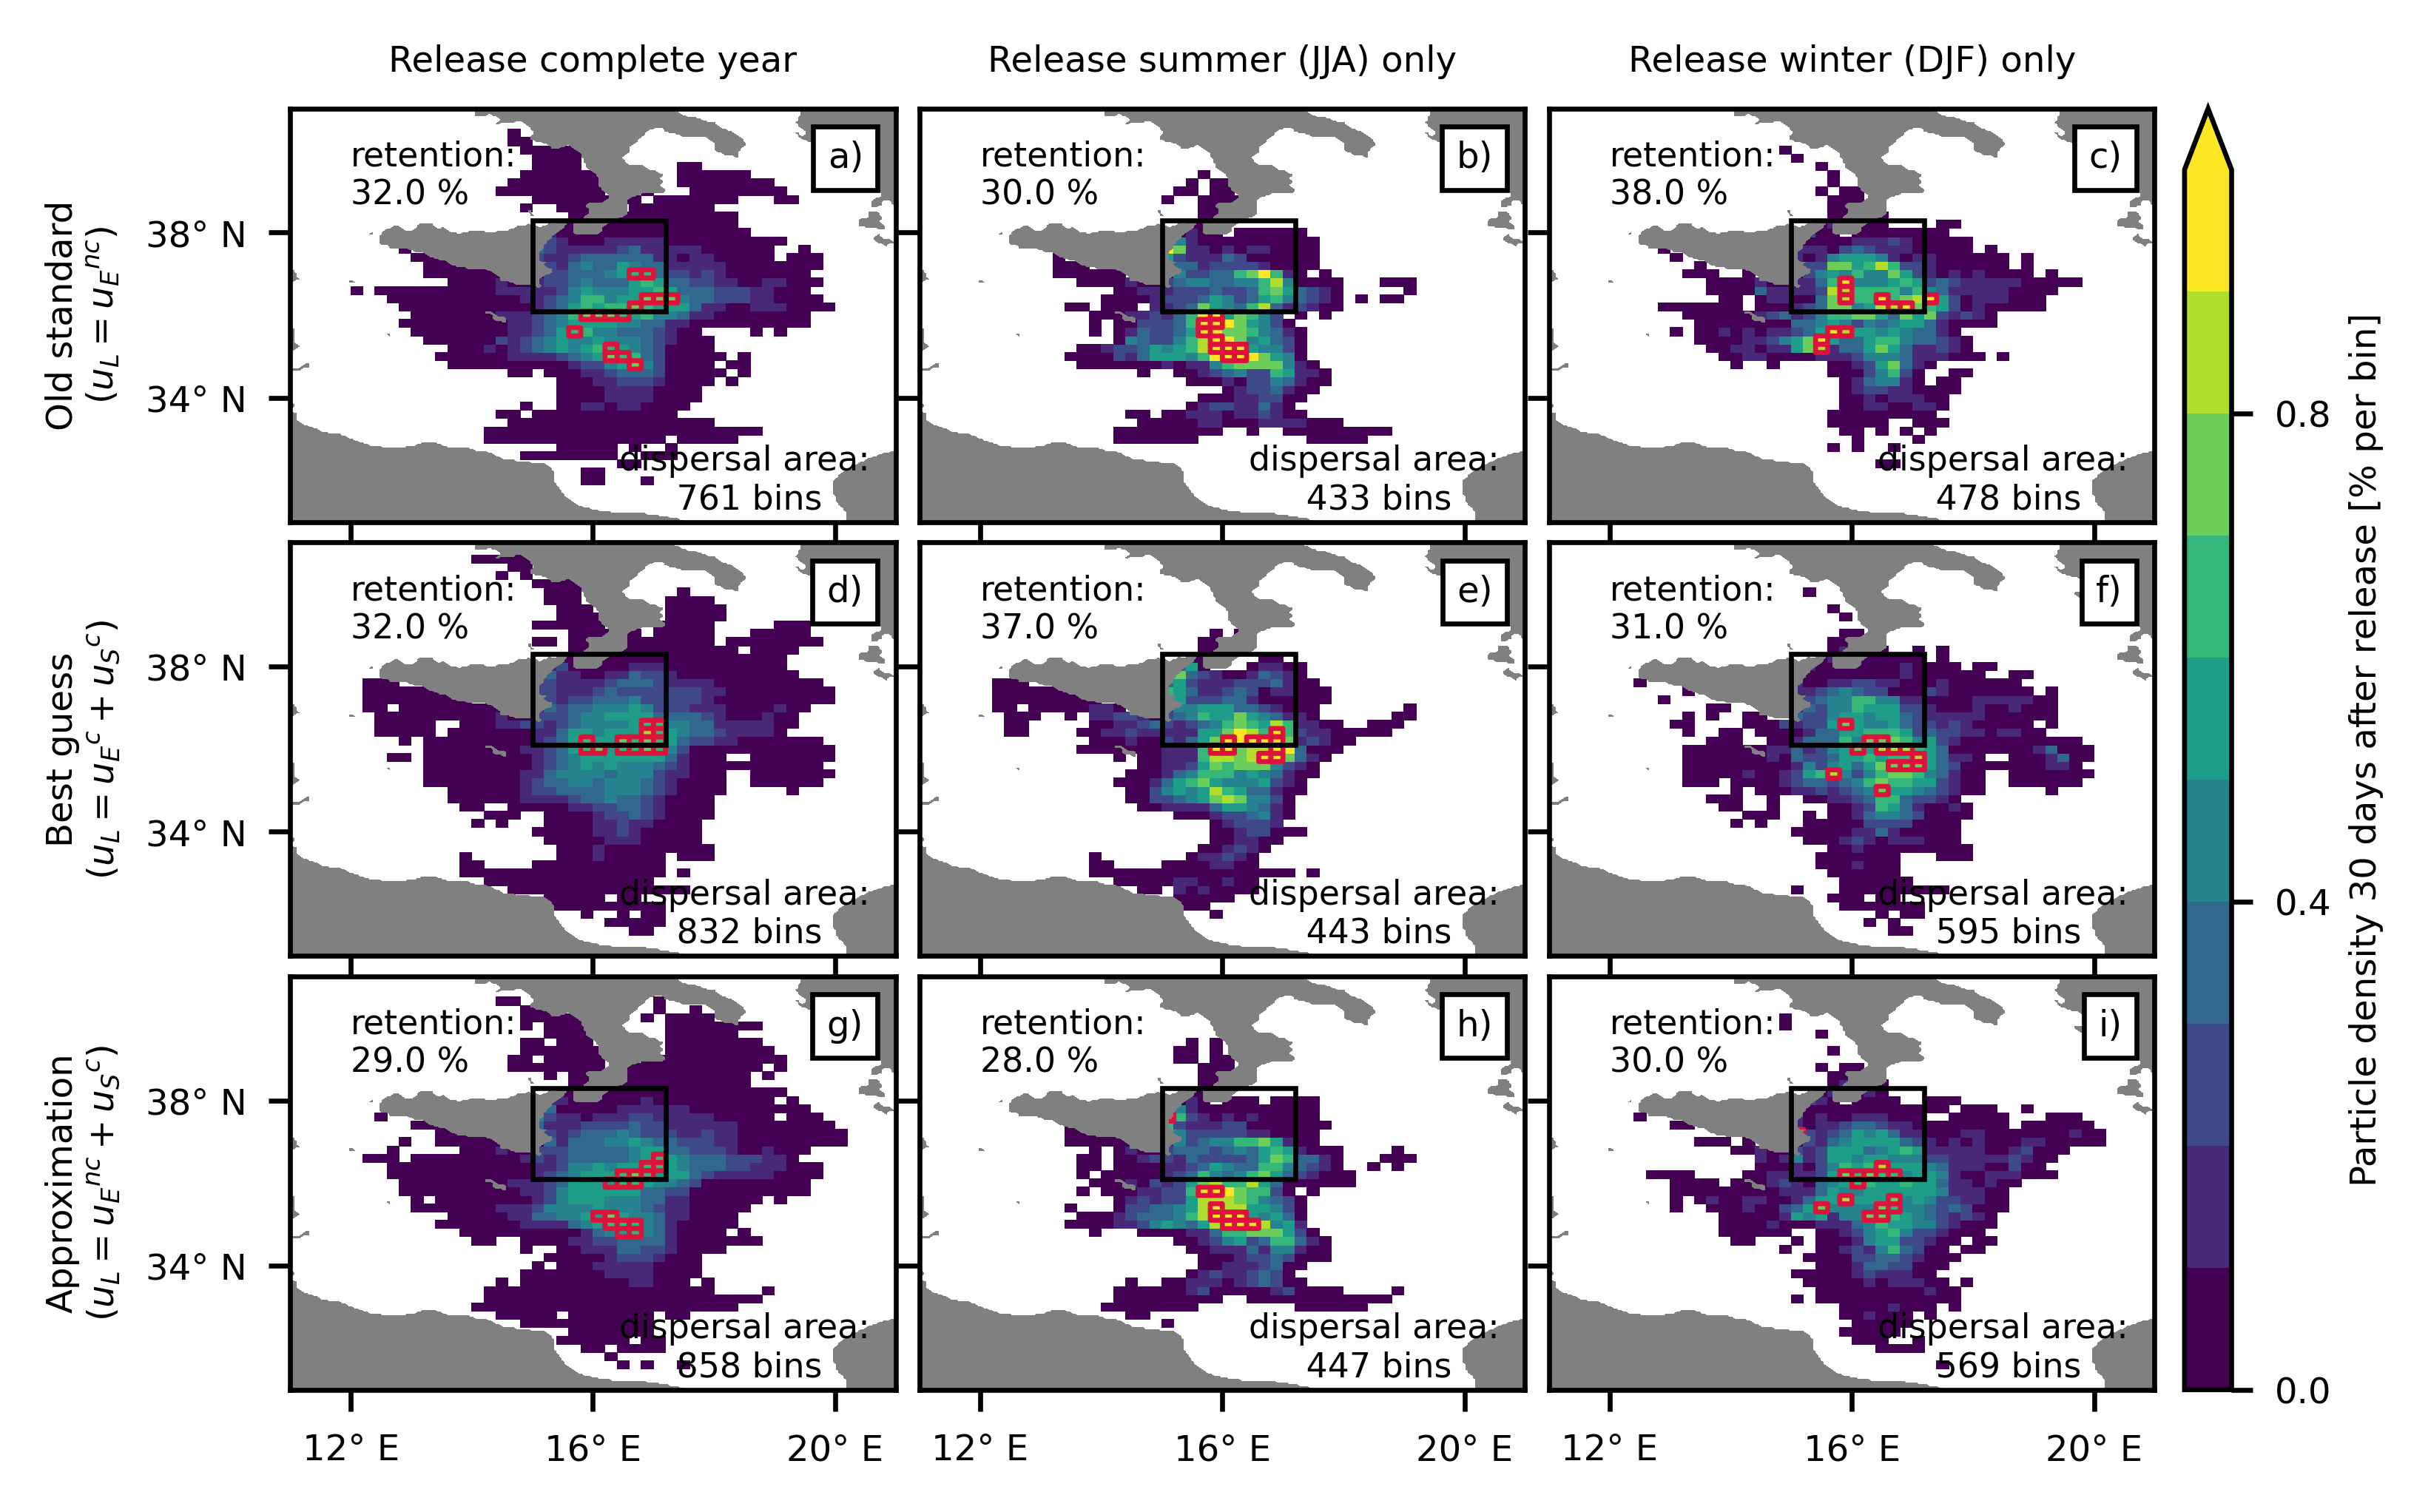

In [26]:
bins_lon = np.arange(-6, 36, 0.2)
bins_lat = np.arange(30.1, 47, 0.2)
lonmin = 15.0
lonmax = 17.0
latmin = 36.1
latmax = 38.1
step = 0.2
lonmin_plot = 11
lonmax_plot = 21
latmin_plot = 31
latmax_plot = 41
highproblev = 90
obstime = 30

colm = cm.viridis
levs = np.arange(0, 1.1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
fs = 'xx-small'
nctic = 3


def plot_2Dhist(var1):
    pos_y = var1.isel(obs=obstime).lat.stack(trajstack=('trajectory', 'start'))
    pos_x = var1.isel(obs=obstime).lon.stack(trajstack=('trajectory', 'start'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm=norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.text(12, 38.5, 'retention:\n' + str(retention.round().values) + ' %', fontsize=5.5,
            ha='left', va='bottom')
    area_bins = (hist2D_plot.where(hist2D_plot != 0) /
                 hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(18.5, 32, 'dispersal area:\n ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5,
            ha='center', va='center')
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin', 'lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(
        tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map


def plot_bathy():
    var = grid.mbathy
    var.rename({'x': 'lon', 'y': 'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0), [0, 1],
                colors='grey')


def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step,
                             linewidth=0.8, edgecolor='k', facecolor='none')
    ax.add_patch(rect)


def build_subplot(var1, xticklabel=True, yticklabel=True):
    map = plot_2Dhist(var1)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot, lonmax_plot])
    ax.set_ylim([latmin_plot, latmax_plot])
    ax.set_xticks([12, 16, 20])
    ax.set_yticks([34, 38])
    ax.set_xticklabels(['12° E', '16° E', '20° E'])
    ax.set_yticklabels(['34° N', '38° N'])
    if xticklabel == False:
        ax.set_xticklabels([])
    if yticklabel == False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map


fig = plt.figure(figsize=(6, 5.6), dpi=600, constrained_layout=False)
gs2 = fig.add_gridspec(nrows=100, ncols=3,
                       left=0.1, right=0.8,
                       wspace=0.03, hspace=0.05)
gs = fig.add_gridspec(nrows=4, ncols=3,
                      left=0.1, right=0.8,
                      top=0.8,
                      wspace=0.04, hspace=0.05)
gscbar = fig.add_gridspec(nrows=4, ncols=100,
                          left=0.1, right=1,
                          top=0.8,
                          wspace=0.04, hspace=0.05)


# Total distributions

ax = fig.add_subplot(gs[1, 0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot(var1, xticklabel=False)
ax.set_title('Release complete year', fontsize=fs)
ax.set_ylabel('Old standard\n($u_L = {u_E}^{nc}$)', fontsize=fs)
at = AnchoredText('a)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[2, 0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot(var1, xticklabel=False)
ax.set_ylabel('Best guess\n($u_L = {u_E}^{c} + {u_S}^{c}$)', fontsize=fs)
at = AnchoredText('d)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[3, 0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot(var1)
ax.set_ylabel('Approximation\n($u_L = {u_E}^{nc} + {u_S}^{c}$)', fontsize=fs)
at = AnchoredText('g)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)


# Summer distributions

start_use = slice(31, 49)

ax = fig.add_subplot(gs[1, 1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release summer (JJA) only', fontsize=fs)
at = AnchoredText('b)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[2, 1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
at = AnchoredText('e)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[3, 1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)
at = AnchoredText('h)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)


# Winter distributions

start1 = np.arange(0, 12)
start2 = np.arange(67, 73)
start_use = [*l1, *l2]

ax = fig.add_subplot(gs[1, 2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release winter (DJF) only', fontsize=fs)
at = AnchoredText('c)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[2, 2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.text(24.5, latmin_plot + (latmax_plot-latmin_plot)/2,
        'Particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
at = AnchoredText('f)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[3, 2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)
at = AnchoredText('i)', prop=dict(size=fs), frameon=True, loc='upper right')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
cbaxes = fig.add_subplot(gscbar[1:5, 79:81])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()

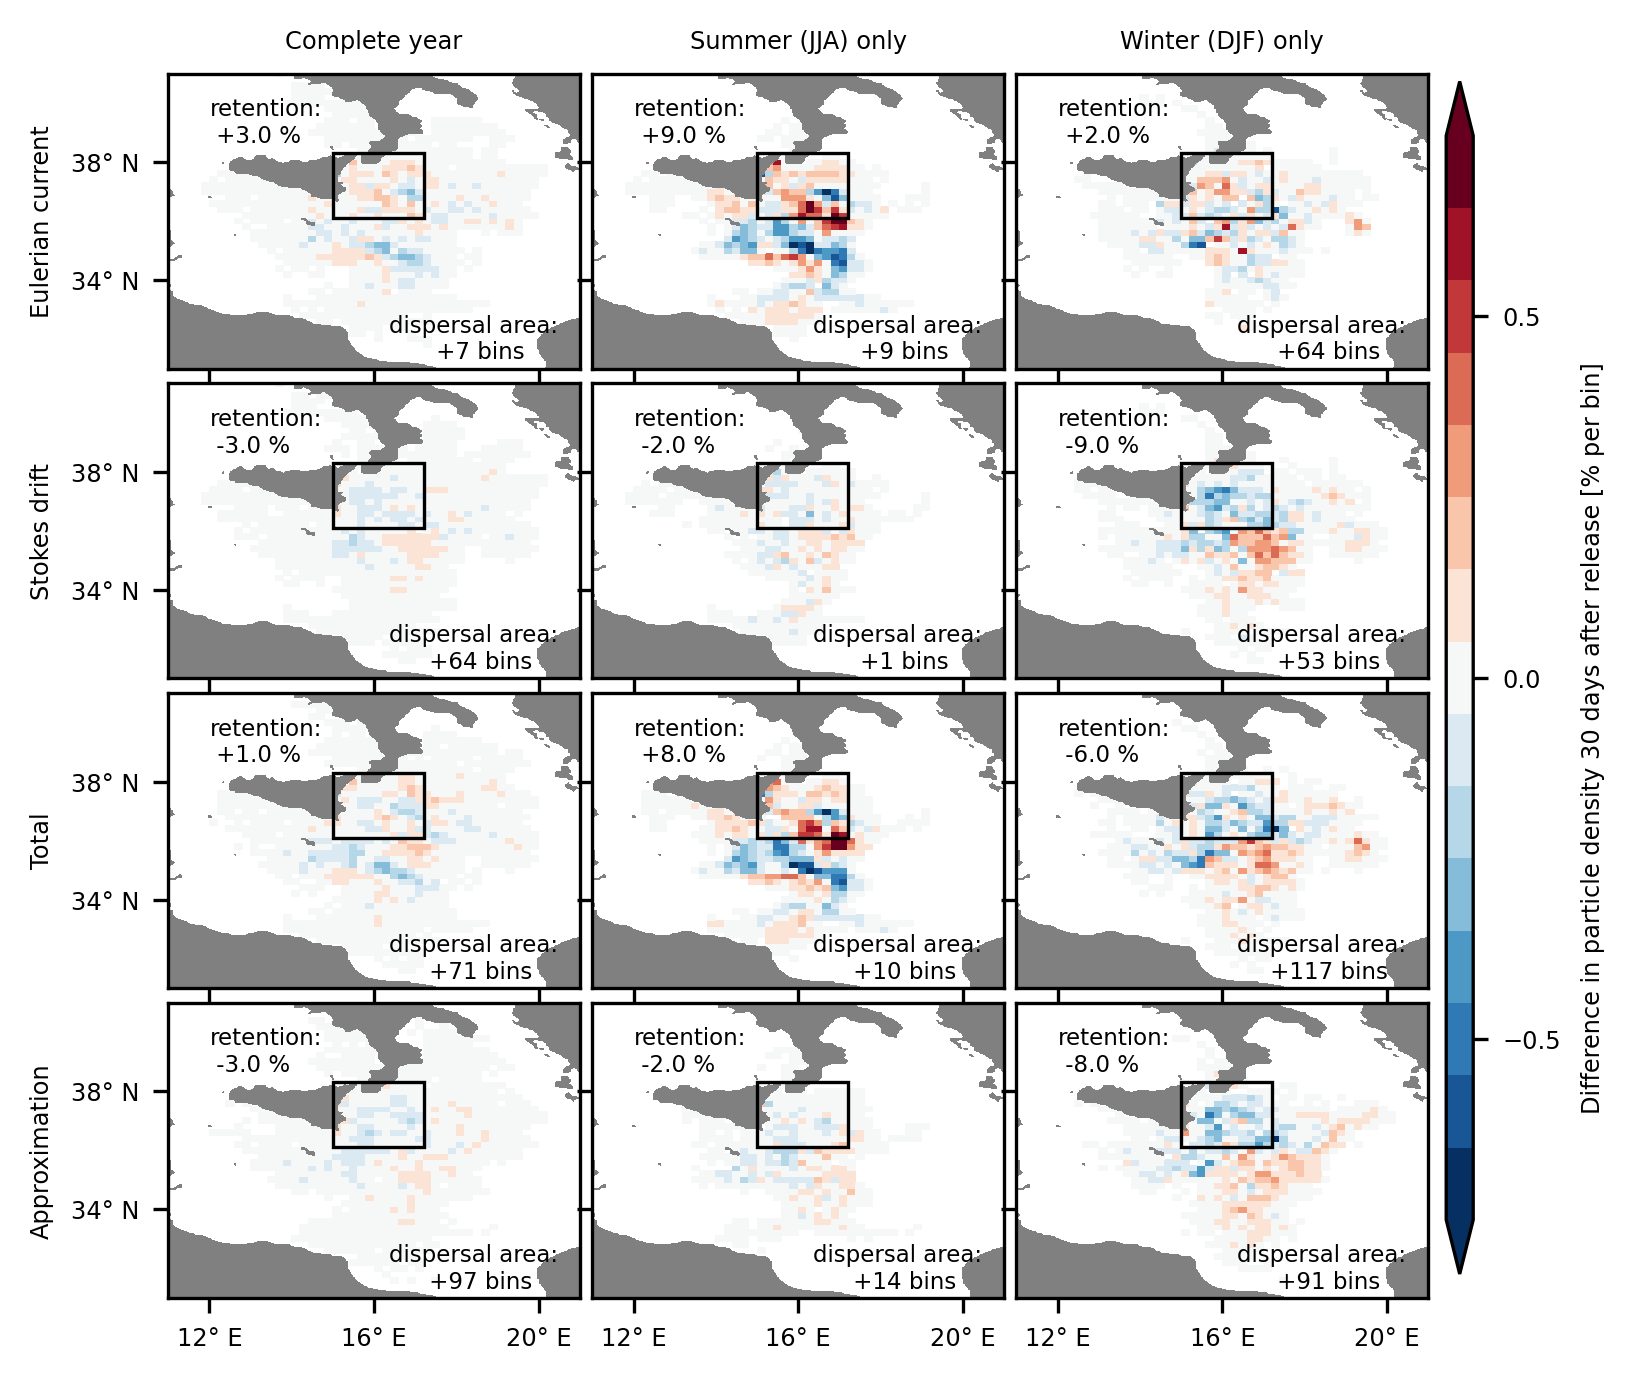

In [27]:
# Plot additional Figure highligtening the differences in the spatial particle distributions between the different Lagrangian simulation types
# useful for the manuscript

bins_lon = np.arange(-6, 36, 0.2)
bins_lat = np.arange(30.1, 47, 0.2)

col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.RdBu_r
levs = np.arange(-0.8, 0.8, 0.1)
norm = colors.BoundaryNorm(boundaries=levs+0.05, ncolors=colm.N)
fs = 'xx-small'
nctic = 3


def plot_2Dhistdiff(var1, var2):
    pos_1y = var1.isel(obs=30).lat.stack(trajstack=('trajectory', 'start'))
    pos_1x = var1.isel(obs=30).lon.stack(trajstack=('trajectory', 'start'))
    hist2D_1 = histogram(pos_1x, pos_1y, bins=[bins_lon, bins_lat])
    hist2D_plot_1 = hist2D_1.transpose()/hist2D_1.sum().values*100
    pos_2y = var2.isel(obs=30).lat.stack(trajstack=('trajectory', 'start'))
    pos_2x = var2.isel(obs=30).lon.stack(trajstack=('trajectory', 'start'))
    hist2D_2 = histogram(pos_2x, pos_2y, bins=[bins_lon, bins_lat])
    hist2D_plot_2 = hist2D_2.transpose()/hist2D_2.sum().values*100
    hist2ddiff = hist2D_plot_1 - hist2D_plot_2
    map = ax.pcolor(hist2ddiff.lon_bin, hist2ddiff.lat_bin,
                    hist2ddiff.where(hist2ddiff != 0),
                    cmap=colm, norm=norm,
                    shading='nearest')
    # plt.colorbar(map)
    release_box = (((hist2D_plot_1.lon_bin >= lonmin) & (hist2D_plot_1.lon_bin <= lonmax)) &
                   ((hist2D_plot_1.lat_bin >= latmin) & (hist2D_plot_1.lat_bin <= latmax)))
    retention1 = hist2D_plot_1.where(release_box).sum()
    retention2 = hist2D_plot_2.where(release_box).sum()
    retentiondiff = retention1 - retention2
    if retentiondiff < 0:
        ax.text(12, 38.5, 'retention:\n -' + str(np.abs(retentiondiff.round().values)) + ' %', fontsize=5.5,
                ha='left', va='bottom')
    if retentiondiff > 0:
        ax.text(12, 38.5, 'retention:\n +' + str(retentiondiff.round().values) + ' %', fontsize=5.5,
                ha='left', va='bottom')
    area_bins_1 = (hist2D_plot_1.where(hist2D_plot_1 != 0) /
                   hist2D_plot_1.where(hist2D_plot_1 != 0)).sum()
    area_bins_2 = (hist2D_plot_2.where(hist2D_plot_2 != 0) /
                   hist2D_plot_2.where(hist2D_plot_2 != 0)).sum()
    area_bins_diff = area_bins_1 - area_bins_2
    if area_bins_diff < 0:
        ax.text(18.5, 32, 'dispersal area: \n-' + str(np.abs(int(area_bins_diff.round().values))) + ' bins', fontsize=5.5,
                ha='center', va='center')
    if area_bins_diff > 0:
        ax.text(18.5, 32, 'dispersal area: \n +' + str(int(area_bins_diff.round().values)) + ' bins', fontsize=5.5,
                ha='center', va='center')
    return map


def plot_bathy():
    var = grid.mbathy
    var.rename({'x': 'lon', 'y': 'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0), [0, 1],
                colors='grey')


def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step,
                             linewidth=0.8, edgecolor='k', facecolor='none')
    ax.add_patch(rect)


def build_subplot(var1, var2, xticklabel=True, yticklabel=True):
    map = plot_2Dhistdiff(var1, var2)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot, lonmax_plot])
    ax.set_ylim([latmin_plot, latmax_plot])
    ax.set_xticks([12, 16, 20])
    ax.set_yticks([34, 38])
    ax.set_xticklabels(['12° E', '16° E', '20° E'])
    ax.set_yticklabels(['34° N', '38° N'])
    if xticklabel == False:
        ax.set_xticklabels([])
    if yticklabel == False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map


fig = plt.figure(figsize=(6, 5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3,
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0, 0])
var1 = traj_cnosd
var2 = traj_nc
map = build_subplot(var1, var2, xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('Eulerian current', fontsize=fs)

ax = fig.add_subplot(gs[1, 0])
var1 = traj_csd
var2 = traj_cnosd
map = build_subplot(var1, var2, xticklabel=False)
ax.set_ylabel('Stokes drift', fontsize=fs)

ax = fig.add_subplot(gs[2, 0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot(var1, var2, xticklabel=False)
ax.set_ylabel('Total', fontsize=fs)

ax = fig.add_subplot(gs[3, 0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot(var1, var2)
ax.set_ylabel('Approximation', fontsize=fs)


# Summer distributions

start_use = slice(31, 49)

ax = fig.add_subplot(gs[0, 1])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1, 1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2, 1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3, 1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, yticklabel=False)


# Winter distributions

start1 = np.arange(0, 12)
start2 = np.arange(67, 73)
start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0, 2])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1, 2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2, 2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3, 2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1, var2, yticklabel=False)
ax.text(25, 50, 'Difference in particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax=cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.minorticks_off()